In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np
## division for train and test
from sklearn.model_selection import train_test_split
##
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from keras.activations import softmax
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.optimizers import SGD
from keras.utils import np_utils

import sys
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user


from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from sklearn.preprocessing import StandardScaler,RobustScaler

Using TensorFlow backend.


## No-K Functions

In [2]:
def plotConfusionMatrix(predictions, true_labels, labels):
    k = true_labels.shape[1]
    n = true_labels.shape[0]
    confusion_matrix = np.zeros((k,k))

    for l in range(n):
        decision = np.zeros(k)
        j = np.argmax(predictions[l])
        decision[j] = 1
        i = np.argmax(true_labels[l])
        confusion_matrix[i,j] +=1
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

def train_test_creator(dic, test_size = 0.2):
    X = []
    Y = []
    #create X and Y with corresponding index
    if type(dic)==dict:
        length = len(dic)
        for count, key in enumerate(dic):
            tmp = dic[key]
            label = np.array(count)
            label = np.resize(label, (tmp.shape[0],1))
            X.append(tmp)
            Y.append(label)
    else:
        return -1
    
    #transform X and Y (lists) in ndarray 
    X = np.vstack(X)
    Y = np.vstack(Y)
    
    #transform Y into 1-hot array
    Y = np_utils.to_categorical(Y, np.max(Y)+1)
    
    #split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    #reshape for conv2d layers
    X_train = np.reshape(X_train, ( X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
    X_test = np.reshape(X_test, ( X_test.shape[0], X_test.shape[1], X_test.shape[2],1))
    
    #save used data for hyperas use
    with open('variables/train_test_split.pkl', 'wb') as f:  
        pickle.dump(X_train, f)
        pickle.dump(y_train, f)
        pickle.dump(X_test, f)
        pickle.dump(y_test, f) 
        
    return X_train, y_train, X_test, y_test 


def findScaler(x, scalerType='standard'):
    #initialize the scaler
    if scalerType == 'robust':
        scaler = RobustScaler()
    elif scalerType == 'standard':
        scaler = StandardScaler()
    temp = []
    #online fit on all data reshaped as array
    for count, sample in enumerate(x):
        sample = np.reshape(sample,(sample.shape[0]*sample.shape[1])).reshape(1, -1)
        temp.append(sample)
    temp=np.vstack(temp)
    scaler.fit(temp)
    return scaler    

def scale(x, scaler):
    #scaling data with the trained scaler  
    temp = []
    for count, sample in enumerate(x):
        sample = np.reshape(sample,(sample.shape[0]*sample.shape[1])).reshape(1, -1)
        temp.append(sample)
    temp=np.vstack(temp)
    temp = scaler.transform(temp)
    for count, sample in enumerate(temp):
        x[count] = np.reshape(sample,(x.shape[1],x.shape[2],1))   

In [3]:
#choose which dictionary to use
choice = 'mfcc'#'spectro'


selected = 0
if choice == 'mfcc':
    
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    
    #name format of the selected data
    name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    
    #saving in usedDict of the mfcc dict
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'spectro':
    
    #saving in usedDict of the spectro dict
    with open('variables/spectroDict.pkl', 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded spectroram')

Loaded variables/mfccDict[nC=13 wL=0.025 wS=0.01].pkl


In [17]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = {'one', 'two', 'three','four','five','six','seven','eight','nine'}
words = {"yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero"}

test = ["yes", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = coreKey

### Estrazione dataset non k-center

In [18]:
#divding between
x_train, y_train, x_test, y_test = train_test_creator({k: usedDict[k] for k in usedDict.keys() & used })
#find the scaler on train
scaler = findScaler(x_train, 'robust')
#print(scaler.mean_,' ',scaler.var_)
print('Scaler found')
#scale data
scale(x_train, scaler)
scale(x_test, scaler)
print('Data scaled')

Scaler found
Data scaled


# A' mejo rete

In [19]:
cnn = Sequential()

cnn.add(Convolution2D(64, (5,4),  strides = (1,1), padding="valid",  activation="softplus",
                      input_shape=(x_train.shape[1], x_train.shape[2],1)))
cnn.add(BatchNormalization())

cnn.add(MaxPooling2D(pool_size=(3,2)))
cnn.add(Dropout(0.4))


cnn.add(Convolution2D(64, (4,2),  strides = (1,1), padding="valid", activation="softplus"))
cnn.add(BatchNormalization())

cnn.add(Convolution2D(256, (4,3),  strides = (1,1), padding="valid", activation="softplus"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(MaxPooling2D(pool_size=(5,1)))


cnn.add(Flatten())

cnn.add(Dense(100, activation="softplus"))
cnn.add(Dropout(0.7))
cnn.add(BatchNormalization())

cnn.add(Dense(y_train.shape[1], activation="sigmoid"))

# define optimizer and objective, compile cnn
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 95, 10, 64)        1344      
_________________________________________________________________
batch_normalization_17 (Batc (None, 95, 10, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 5, 64)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 31, 5, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 4, 64)         32832     
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 4, 64)         256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 2, 256)        196864    
__________

In [20]:
epoch = 40
compiled = cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
fitted = cnn.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test), batch_size=round(x_train.shape[0]/250))

Train on 37878 samples, validate on 9470 samples
Epoch 1/40
37878/37878 [==============================] - 10s 256us/step - loss: 2.5427 - acc: 0.2826 - val_loss: 2.0092 - val_acc: 0.5846
Epoch 2/40
37878/37878 [==============================] - 8s 217us/step - loss: 1.6939 - acc: 0.5318 - val_loss: 1.1025 - val_acc: 0.6704
Epoch 3/40
37878/37878 [==============================] - 8s 216us/step - loss: 0.9944 - acc: 0.7170 - val_loss: 0.5620 - val_acc: 0.8579
Epoch 4/40
37878/37878 [==============================] - 8s 217us/step - loss: 0.7224 - acc: 0.7965 - val_loss: 0.4035 - val_acc: 0.8908
Epoch 5/40
37878/37878 [==============================] - 8s 217us/step - loss: 0.5901 - acc: 0.8359 - val_loss: 0.3165 - val_acc: 0.9137
Epoch 6/40
37878/37878 [==============================] - 8s 218us/step - loss: 0.5076 - acc: 0.8587 - val_loss: 0.2715 - val_acc: 0.9285
Epoch 7/40
37878/37878 [==============================] - 8s 217us/step - loss: 0.4591 - acc: 0.8719 - val_loss: 0.2639 - 

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


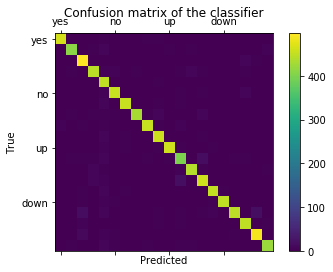

9470/9470 [==============================] - 1s 123us/step
Precision:  95.04 %


In [21]:
#find prediction with test data
preds = cnn.predict(x_test)
print(list(used))

#plot confusion matrix
plotConfusionMatrix(preds,y_test,list(used))
loss, precision = cnn.evaluate(x_test,y_test)
print ("Precision: ", round(precision*100,2),"%")

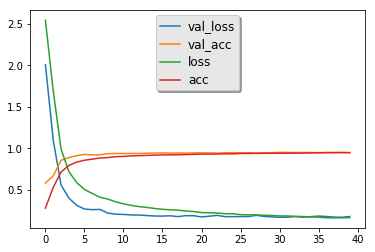

In [22]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fitted.history:
    ax.plot(x,fitted.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


# Looking for hyperparameters

In [6]:

def data():
    #load used data
    with open('variables/train_test_split.pkl', 'rb') as f: 
        x_train = pickle.load(f)
        y_train = pickle.load(f)
        x_test = pickle.load(f)
        y_test = pickle.load(f) 
    return x_train, y_train, x_test, y_test 

def create_model(x_train, y_train, x_test, y_test):
    cnn = Sequential()
    input_shape = (1, x_train.shape[2], x_train.shape[3])
    cnn.add(Convolution2D({{choice([32,64,128])}}, (5,4),  strides = (1,1), padding="valid", input_shape=input_shape))
    cnn.add(Activation("softplus"))
    cnn.add(MaxPooling2D(pool_size=(3,2)))
    cnn.add(Dropout({{uniform(0, 1)}}))

    cnn.add(Convolution2D({{choice([64,128,256])}}, (4,2),  strides = (1,1), padding="valid"))
    cnn.add(Activation("softplus"))
    cnn.add(Convolution2D({{choice([64,128,256])}}, (4,3),  strides = (1,1), padding="valid"))
    cnn.add(Activation("softplus"))
    cnn.add(MaxPooling2D(pool_size=(5,1)))
    cnn.add(Dropout({{uniform(0, 1)}}))

    cnn.add(Flatten())

    cnn.add(Dense({{choice([60, 80, 100])}}))
    cnn.add(Activation("softplus"))
    cnn.add(Dropout({{uniform(0, 1)}}))

    cnn.add(Dense(y_train.shape[1]))
    cnn.add(Activation({{choice(['softmax', 'sigmoid'])}}))
    cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
            
    cnn.fit(x_train, y_train,
              batch_size={{choice([128, 256])}},
              epochs=10,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = cnn.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': cnn}

In [7]:
#from keras.layers.core import Dense, Dropout, Activation
trials = Trials()
best_run, best_model = optim.minimize(model=create_model, 
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=trials,
                                      notebook_name='processing')

>>> Imports:
#coding=utf-8

try:
    import sys
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pickle
except:
    pass

try:
    from glob import glob
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.decomposition import PCA
except:
    pass

try:
    from sklearn.preprocessing import normalize
except:
    pass

try:
    from keras.activations import softmax
except:
    pass

try:
    from keras.models import Sequential, load_model
except:
    pass

try:
    from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.optimizers import SGD
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    import sys
except:
    pass

try:
    from hyperas import opt

Epoch 9/40
 - 2s - loss: 1.7344 - acc: 0.3794 - val_loss: 1.2899 - val_acc: 0.6942
Epoch 10/40
 - 2s - loss: 1.5901 - acc: 0.4345 - val_loss: 1.1033 - val_acc: 0.7364
Epoch 11/40
 - 2s - loss: 1.4845 - acc: 0.4744 - val_loss: 0.9851 - val_acc: 0.7665
Epoch 12/40
 - 2s - loss: 1.3710 - acc: 0.5214 - val_loss: 0.8542 - val_acc: 0.7855
Epoch 13/40
 - 2s - loss: 1.2582 - acc: 0.5582 - val_loss: 0.7552 - val_acc: 0.8010
Epoch 14/40
 - 2s - loss: 1.1839 - acc: 0.5877 - val_loss: 0.6614 - val_acc: 0.8198
Epoch 15/40
 - 2s - loss: 1.0875 - acc: 0.6210 - val_loss: 0.6244 - val_acc: 0.8183
Epoch 16/40
 - 2s - loss: 1.0399 - acc: 0.6389 - val_loss: 0.5424 - val_acc: 0.8477
Epoch 17/40
 - 2s - loss: 0.9572 - acc: 0.6692 - val_loss: 0.5030 - val_acc: 0.8540
Epoch 18/40
 - 2s - loss: 0.9139 - acc: 0.6906 - val_loss: 0.4643 - val_acc: 0.8634
Epoch 19/40
 - 2s - loss: 0.8753 - acc: 0.7030 - val_loss: 0.4593 - val_acc: 0.8605
Epoch 20/40
 - 2s - loss: 0.8408 - acc: 0.7122 - val_loss: 0.4433 - val_acc: 

Epoch 25/40
 - 2s - loss: 0.6301 - acc: 0.8017 - val_loss: 0.3596 - val_acc: 0.8883
Epoch 26/40
 - 2s - loss: 0.6299 - acc: 0.8023 - val_loss: 0.3338 - val_acc: 0.8956
Epoch 27/40
 - 2s - loss: 0.5980 - acc: 0.8098 - val_loss: 0.3231 - val_acc: 0.9027
Epoch 28/40
 - 2s - loss: 0.5912 - acc: 0.8146 - val_loss: 0.3095 - val_acc: 0.9058
Epoch 29/40
 - 2s - loss: 0.5780 - acc: 0.8197 - val_loss: 0.3313 - val_acc: 0.8939
Epoch 30/40
 - 2s - loss: 0.5616 - acc: 0.8259 - val_loss: 0.3161 - val_acc: 0.9002
Epoch 31/40
 - 2s - loss: 0.5585 - acc: 0.8257 - val_loss: 0.2994 - val_acc: 0.9075
Epoch 32/40
 - 2s - loss: 0.5395 - acc: 0.8325 - val_loss: 0.3032 - val_acc: 0.9046
Epoch 33/40
 - 2s - loss: 0.5350 - acc: 0.8360 - val_loss: 0.2918 - val_acc: 0.9100
Epoch 34/40
 - 2s - loss: 0.5159 - acc: 0.8408 - val_loss: 0.2847 - val_acc: 0.9152
Epoch 35/40
 - 2s - loss: 0.5150 - acc: 0.8394 - val_loss: 0.2756 - val_acc: 0.9177
Epoch 36/40
 - 2s - loss: 0.5012 - acc: 0.8446 - val_loss: 0.3044 - val_acc:

Test accuracy: 0.9265157330155098
Train on 20846 samples, validate on 5212 samples
Epoch 1/40
 - 3s - loss: 2.4312 - acc: 0.1002 - val_loss: 2.3198 - val_acc: 0.1466
Epoch 2/40
 - 3s - loss: 2.1933 - acc: 0.1897 - val_loss: 1.8880 - val_acc: 0.3078
Epoch 3/40
 - 3s - loss: 1.9525 - acc: 0.2663 - val_loss: 1.6825 - val_acc: 0.4457
Epoch 4/40
 - 3s - loss: 1.8041 - acc: 0.3322 - val_loss: 1.4916 - val_acc: 0.5351
Epoch 5/40
 - 3s - loss: 1.6299 - acc: 0.4100 - val_loss: 1.2310 - val_acc: 0.6539
Epoch 6/40
 - 3s - loss: 1.3673 - acc: 0.5112 - val_loss: 0.9290 - val_acc: 0.7323
Epoch 7/40
 - 3s - loss: 1.1241 - acc: 0.6083 - val_loss: 0.6994 - val_acc: 0.8003
Epoch 8/40
 - 3s - loss: 0.9110 - acc: 0.6886 - val_loss: 0.5652 - val_acc: 0.8252
Epoch 9/40
 - 3s - loss: 0.7557 - acc: 0.7500 - val_loss: 0.4806 - val_acc: 0.8459
Epoch 10/40
 - 3s - loss: 0.6539 - acc: 0.7812 - val_loss: 0.4251 - val_acc: 0.8640
Epoch 11/40
 - 3s - loss: 0.5764 - acc: 0.8109 - val_loss: 0.3793 - val_acc: 0.8799
Ep

Epoch 16/40
 - 2s - loss: 0.5734 - acc: 0.8168 - val_loss: 0.3617 - val_acc: 0.8889
Epoch 17/40
 - 2s - loss: 0.5405 - acc: 0.8261 - val_loss: 0.3431 - val_acc: 0.8897
Epoch 18/40
 - 2s - loss: 0.5204 - acc: 0.8319 - val_loss: 0.3390 - val_acc: 0.8929
Epoch 19/40
 - 2s - loss: 0.4892 - acc: 0.8436 - val_loss: 0.3122 - val_acc: 0.8993
Epoch 20/40
 - 2s - loss: 0.4712 - acc: 0.8478 - val_loss: 0.3004 - val_acc: 0.9071
Epoch 21/40
 - 2s - loss: 0.4528 - acc: 0.8558 - val_loss: 0.2983 - val_acc: 0.9052
Epoch 22/40
 - 2s - loss: 0.4398 - acc: 0.8615 - val_loss: 0.2967 - val_acc: 0.9016
Epoch 23/40
 - 2s - loss: 0.4318 - acc: 0.8618 - val_loss: 0.2785 - val_acc: 0.9121
Epoch 24/40
 - 2s - loss: 0.4084 - acc: 0.8688 - val_loss: 0.2713 - val_acc: 0.9144
Epoch 25/40
 - 2s - loss: 0.4013 - acc: 0.8745 - val_loss: 0.2617 - val_acc: 0.9154
Epoch 26/40
 - 2s - loss: 0.3842 - acc: 0.8781 - val_loss: 0.2619 - val_acc: 0.9150
Epoch 27/40
 - 2s - loss: 0.3741 - acc: 0.8805 - val_loss: 0.2613 - val_acc:

Epoch 32/40
 - 1s - loss: 0.3627 - acc: 0.8812 - val_loss: 0.2750 - val_acc: 0.9135
Epoch 33/40
 - 1s - loss: 0.3561 - acc: 0.8845 - val_loss: 0.2575 - val_acc: 0.9206
Epoch 34/40
 - 1s - loss: 0.3508 - acc: 0.8870 - val_loss: 0.2666 - val_acc: 0.9185
Epoch 35/40
 - 1s - loss: 0.3362 - acc: 0.8901 - val_loss: 0.2563 - val_acc: 0.9223
Epoch 36/40
 - 1s - loss: 0.3315 - acc: 0.8919 - val_loss: 0.2529 - val_acc: 0.9217
Epoch 37/40
 - 1s - loss: 0.3242 - acc: 0.8930 - val_loss: 0.2612 - val_acc: 0.9198
Epoch 38/40
 - 1s - loss: 0.3089 - acc: 0.8978 - val_loss: 0.2482 - val_acc: 0.9233
Epoch 39/40
 - 1s - loss: 0.3119 - acc: 0.8961 - val_loss: 0.2473 - val_acc: 0.9236
Epoch 40/40
 - 1s - loss: 0.2994 - acc: 0.9022 - val_loss: 0.2437 - val_acc: 0.9269
Test accuracy: 0.9268994626409717
Train on 20846 samples, validate on 5212 samples
Epoch 1/40
 - 4s - loss: 2.7121 - acc: 0.0925 - val_loss: 2.3983 - val_acc: 0.0877
Epoch 2/40
 - 3s - loss: 2.5438 - acc: 0.0909 - val_loss: 2.3988 - val_acc: 0.

Epoch 7/40
 - 3s - loss: 2.1831 - acc: 0.1854 - val_loss: 1.9881 - val_acc: 0.3066
Epoch 8/40
 - 3s - loss: 2.0575 - acc: 0.2348 - val_loss: 1.8149 - val_acc: 0.4269
Epoch 9/40
 - 3s - loss: 1.9656 - acc: 0.2674 - val_loss: 1.7066 - val_acc: 0.5094
Epoch 10/40
 - 3s - loss: 1.8633 - acc: 0.3019 - val_loss: 1.5451 - val_acc: 0.5234
Epoch 11/40
 - 3s - loss: 1.7436 - acc: 0.3441 - val_loss: 1.3695 - val_acc: 0.5909
Epoch 12/40
 - 3s - loss: 1.6387 - acc: 0.3807 - val_loss: 1.2122 - val_acc: 0.6305
Epoch 13/40
 - 3s - loss: 1.5182 - acc: 0.4240 - val_loss: 1.0460 - val_acc: 0.6840
Epoch 14/40
 - 3s - loss: 1.4048 - acc: 0.4664 - val_loss: 0.9445 - val_acc: 0.7001
Epoch 15/40
 - 3s - loss: 1.3228 - acc: 0.4986 - val_loss: 0.7846 - val_acc: 0.7414
Epoch 16/40
 - 3s - loss: 1.2375 - acc: 0.5336 - val_loss: 0.6948 - val_acc: 0.7630
Epoch 17/40
 - 3s - loss: 1.1529 - acc: 0.5683 - val_loss: 0.6560 - val_acc: 0.7746
Epoch 18/40
 - 3s - loss: 1.0840 - acc: 0.5948 - val_loss: 0.6010 - val_acc: 0.

Epoch 23/40
 - 2s - loss: 1.8706 - acc: 0.2981 - val_loss: 1.5521 - val_acc: 0.5503
Epoch 24/40
 - 2s - loss: 1.8540 - acc: 0.2973 - val_loss: 1.5065 - val_acc: 0.5541
Epoch 25/40
 - 2s - loss: 1.8400 - acc: 0.3094 - val_loss: 1.4816 - val_acc: 0.5670
Epoch 26/40
 - 2s - loss: 1.8109 - acc: 0.3173 - val_loss: 1.4570 - val_acc: 0.5735
Epoch 27/40
 - 2s - loss: 1.7880 - acc: 0.3308 - val_loss: 1.4328 - val_acc: 0.5658
Epoch 28/40
 - 2s - loss: 1.7567 - acc: 0.3462 - val_loss: 1.4430 - val_acc: 0.5737
Epoch 29/40
 - 2s - loss: 1.7517 - acc: 0.3496 - val_loss: 1.4025 - val_acc: 0.5817
Epoch 30/40
 - 2s - loss: 1.7440 - acc: 0.3503 - val_loss: 1.4122 - val_acc: 0.5794
Epoch 31/40
 - 2s - loss: 1.7221 - acc: 0.3614 - val_loss: 1.3729 - val_acc: 0.5808
Epoch 32/40
 - 2s - loss: 1.6956 - acc: 0.3634 - val_loss: 1.3322 - val_acc: 0.5927
Epoch 33/40
 - 2s - loss: 1.6756 - acc: 0.3728 - val_loss: 1.3235 - val_acc: 0.5888
Epoch 34/40
 - 2s - loss: 1.6735 - acc: 0.3772 - val_loss: 1.3294 - val_acc:

Epoch 39/40
 - 2s - loss: 0.6454 - acc: 0.7843 - val_loss: 0.3415 - val_acc: 0.8998
Epoch 40/40
 - 2s - loss: 0.6204 - acc: 0.7940 - val_loss: 0.3310 - val_acc: 0.9004
Test accuracy: 0.9004221027938567
Train on 20846 samples, validate on 5212 samples
Epoch 1/40
 - 3s - loss: 2.5088 - acc: 0.1064 - val_loss: 2.3313 - val_acc: 0.1527
Epoch 2/40
 - 2s - loss: 2.2135 - acc: 0.1993 - val_loss: 1.8760 - val_acc: 0.3701
Epoch 3/40
 - 2s - loss: 1.8473 - acc: 0.3593 - val_loss: 1.4727 - val_acc: 0.5259
Epoch 4/40
 - 2s - loss: 1.5365 - acc: 0.4782 - val_loss: 1.1675 - val_acc: 0.6251
Epoch 5/40
 - 2s - loss: 1.2716 - acc: 0.5734 - val_loss: 0.9306 - val_acc: 0.7009
Epoch 6/40
 - 2s - loss: 1.0745 - acc: 0.6395 - val_loss: 0.7881 - val_acc: 0.7421
Epoch 7/40
 - 2s - loss: 0.9506 - acc: 0.6844 - val_loss: 0.6755 - val_acc: 0.7792
Epoch 8/40
 - 2s - loss: 0.8342 - acc: 0.7276 - val_loss: 0.5952 - val_acc: 0.8060
Epoch 9/40
 - 2s - loss: 0.7386 - acc: 0.7584 - val_loss: 0.5438 - val_acc: 0.8271
Ep

Epoch 14/40
 - 3s - loss: 0.3081 - acc: 0.9006 - val_loss: 0.2629 - val_acc: 0.9188
Epoch 15/40
 - 3s - loss: 0.2874 - acc: 0.9087 - val_loss: 0.3227 - val_acc: 0.9056
Epoch 16/40
 - 3s - loss: 0.2690 - acc: 0.9161 - val_loss: 0.2458 - val_acc: 0.9200
Epoch 17/40
 - 3s - loss: 0.2362 - acc: 0.9238 - val_loss: 0.2438 - val_acc: 0.9250
Epoch 18/40
 - 3s - loss: 0.2324 - acc: 0.9230 - val_loss: 0.2333 - val_acc: 0.9298
Epoch 19/40
 - 3s - loss: 0.2109 - acc: 0.9314 - val_loss: 0.2526 - val_acc: 0.9227
Epoch 20/40
 - 3s - loss: 0.2037 - acc: 0.9345 - val_loss: 0.2543 - val_acc: 0.9286
Epoch 21/40
 - 3s - loss: 0.1999 - acc: 0.9367 - val_loss: 0.2401 - val_acc: 0.9282
Epoch 22/40
 - 3s - loss: 0.1872 - acc: 0.9396 - val_loss: 0.2316 - val_acc: 0.9365
Epoch 23/40
 - 3s - loss: 0.1782 - acc: 0.9414 - val_loss: 0.2604 - val_acc: 0.9325
Epoch 24/40
 - 3s - loss: 0.1595 - acc: 0.9476 - val_loss: 0.2548 - val_acc: 0.9330
Epoch 25/40
 - 3s - loss: 0.1657 - acc: 0.9474 - val_loss: 0.2382 - val_acc:

Epoch 30/40
 - 3s - loss: 0.0999 - acc: 0.9656 - val_loss: 0.2477 - val_acc: 0.9340
Epoch 31/40
 - 3s - loss: 0.0984 - acc: 0.9667 - val_loss: 0.2269 - val_acc: 0.9386
Epoch 32/40
 - 3s - loss: 0.0928 - acc: 0.9691 - val_loss: 0.2205 - val_acc: 0.9398
Epoch 33/40
 - 3s - loss: 0.0853 - acc: 0.9724 - val_loss: 0.2338 - val_acc: 0.9396
Epoch 34/40
 - 3s - loss: 0.0863 - acc: 0.9709 - val_loss: 0.2383 - val_acc: 0.9388
Epoch 35/40
 - 3s - loss: 0.0870 - acc: 0.9711 - val_loss: 0.2164 - val_acc: 0.9399
Epoch 36/40
 - 3s - loss: 0.0854 - acc: 0.9706 - val_loss: 0.2478 - val_acc: 0.9422
Epoch 37/40
 - 3s - loss: 0.0726 - acc: 0.9759 - val_loss: 0.2509 - val_acc: 0.9380
Epoch 38/40
 - 3s - loss: 0.0782 - acc: 0.9736 - val_loss: 0.2381 - val_acc: 0.9376
Epoch 39/40
 - 3s - loss: 0.0793 - acc: 0.9738 - val_loss: 0.2451 - val_acc: 0.9403
Epoch 40/40
 - 3s - loss: 0.0733 - acc: 0.9761 - val_loss: 0.2610 - val_acc: 0.9386
Test accuracy: 0.938603223285031
Train on 20846 samples, validate on 5212 sa

Epoch 5/40
 - 3s - loss: 1.0997 - acc: 0.6313 - val_loss: 0.6394 - val_acc: 0.8068
Epoch 6/40
 - 3s - loss: 0.8720 - acc: 0.7046 - val_loss: 0.5326 - val_acc: 0.8358
Epoch 7/40
 - 3s - loss: 0.7318 - acc: 0.7636 - val_loss: 0.4306 - val_acc: 0.8699
Epoch 8/40
 - 3s - loss: 0.6225 - acc: 0.7998 - val_loss: 0.3655 - val_acc: 0.8862
Epoch 9/40
 - 3s - loss: 0.5524 - acc: 0.8216 - val_loss: 0.3357 - val_acc: 0.8950
Epoch 10/40
 - 3s - loss: 0.4848 - acc: 0.8446 - val_loss: 0.3232 - val_acc: 0.8987
Epoch 11/40
 - 3s - loss: 0.4402 - acc: 0.8583 - val_loss: 0.3159 - val_acc: 0.8998
Epoch 12/40
 - 3s - loss: 0.4065 - acc: 0.8701 - val_loss: 0.2849 - val_acc: 0.9123
Epoch 13/40
 - 3s - loss: 0.3666 - acc: 0.8818 - val_loss: 0.2732 - val_acc: 0.9154
Epoch 14/40
 - 3s - loss: 0.3434 - acc: 0.8920 - val_loss: 0.2994 - val_acc: 0.9104
Epoch 15/40
 - 3s - loss: 0.3170 - acc: 0.8999 - val_loss: 0.2636 - val_acc: 0.9225
Epoch 16/40
 - 3s - loss: 0.3014 - acc: 0.9055 - val_loss: 0.2489 - val_acc: 0.92

Epoch 21/40
 - 3s - loss: 0.3786 - acc: 0.8762 - val_loss: 0.2774 - val_acc: 0.9204
Epoch 22/40
 - 3s - loss: 0.3569 - acc: 0.8843 - val_loss: 0.2419 - val_acc: 0.9259
Epoch 23/40
 - 3s - loss: 0.3593 - acc: 0.8845 - val_loss: 0.2763 - val_acc: 0.9215
Epoch 24/40
 - 3s - loss: 0.3413 - acc: 0.8887 - val_loss: 0.2512 - val_acc: 0.9273
Epoch 25/40
 - 3s - loss: 0.3283 - acc: 0.8956 - val_loss: 0.2444 - val_acc: 0.9265
Epoch 26/40
 - 3s - loss: 0.3274 - acc: 0.8964 - val_loss: 0.2411 - val_acc: 0.9279
Epoch 27/40
 - 3s - loss: 0.3120 - acc: 0.8980 - val_loss: 0.2485 - val_acc: 0.9234
Epoch 28/40
 - 3s - loss: 0.3019 - acc: 0.9018 - val_loss: 0.2297 - val_acc: 0.9286
Epoch 29/40
 - 3s - loss: 0.2914 - acc: 0.9063 - val_loss: 0.2566 - val_acc: 0.9269
Epoch 30/40
 - 3s - loss: 0.2868 - acc: 0.9072 - val_loss: 0.2267 - val_acc: 0.9338
Epoch 31/40
 - 3s - loss: 0.2744 - acc: 0.9097 - val_loss: 0.2478 - val_acc: 0.9311
Epoch 32/40
 - 3s - loss: 0.2652 - acc: 0.9148 - val_loss: 0.2451 - val_acc:

Epoch 37/40
 - 3s - loss: 0.1493 - acc: 0.9540 - val_loss: 0.2376 - val_acc: 0.9371
Epoch 38/40
 - 3s - loss: 0.1424 - acc: 0.9543 - val_loss: 0.2551 - val_acc: 0.9351
Epoch 39/40
 - 3s - loss: 0.1346 - acc: 0.9570 - val_loss: 0.2561 - val_acc: 0.9367
Epoch 40/40
 - 3s - loss: 0.1464 - acc: 0.9556 - val_loss: 0.2587 - val_acc: 0.9355
Test accuracy: 0.9355333845888022
Train on 20846 samples, validate on 5212 samples
Epoch 1/40
 - 5s - loss: 2.3825 - acc: 0.1243 - val_loss: 2.1058 - val_acc: 0.2661
Epoch 2/40
 - 3s - loss: 2.0203 - acc: 0.2675 - val_loss: 1.6360 - val_acc: 0.4624
Epoch 3/40
 - 3s - loss: 1.6641 - acc: 0.4285 - val_loss: 1.1483 - val_acc: 0.6303
Epoch 4/40
 - 3s - loss: 1.3041 - acc: 0.5686 - val_loss: 0.7999 - val_acc: 0.7602
Epoch 5/40
 - 3s - loss: 1.0105 - acc: 0.6750 - val_loss: 0.6301 - val_acc: 0.8064
Epoch 6/40
 - 3s - loss: 0.8312 - acc: 0.7380 - val_loss: 0.4906 - val_acc: 0.8390
Epoch 7/40
 - 3s - loss: 0.7223 - acc: 0.7715 - val_loss: 0.4437 - val_acc: 0.8573


Epoch 12/40
 - 4s - loss: 1.0178 - acc: 0.6679 - val_loss: 0.5279 - val_acc: 0.8367
Epoch 13/40
 - 4s - loss: 0.9289 - acc: 0.6908 - val_loss: 0.4993 - val_acc: 0.8469
Epoch 14/40
 - 4s - loss: 0.8630 - acc: 0.7162 - val_loss: 0.4431 - val_acc: 0.8642
Epoch 15/40
 - 4s - loss: 0.8185 - acc: 0.7299 - val_loss: 0.4032 - val_acc: 0.8799
Epoch 16/40
 - 4s - loss: 0.7676 - acc: 0.7470 - val_loss: 0.3958 - val_acc: 0.8803
Epoch 17/40
 - 4s - loss: 0.7031 - acc: 0.7727 - val_loss: 0.3513 - val_acc: 0.8876
Epoch 18/40
 - 4s - loss: 0.6719 - acc: 0.7767 - val_loss: 0.3314 - val_acc: 0.8962
Epoch 19/40
 - 4s - loss: 0.6507 - acc: 0.7885 - val_loss: 0.3235 - val_acc: 0.9012
Epoch 20/40
 - 4s - loss: 0.6187 - acc: 0.7992 - val_loss: 0.3175 - val_acc: 0.9045
Epoch 21/40
 - 4s - loss: 0.5816 - acc: 0.8106 - val_loss: 0.2982 - val_acc: 0.9098
Epoch 22/40
 - 4s - loss: 0.5628 - acc: 0.8150 - val_loss: 0.2794 - val_acc: 0.9133
Epoch 23/40
 - 4s - loss: 0.5347 - acc: 0.8225 - val_loss: 0.2621 - val_acc:

Epoch 28/40
 - 3s - loss: 0.2829 - acc: 0.9085 - val_loss: 0.2311 - val_acc: 0.9248
Epoch 29/40
 - 2s - loss: 0.2852 - acc: 0.9056 - val_loss: 0.2342 - val_acc: 0.9263
Epoch 30/40
 - 2s - loss: 0.2735 - acc: 0.9129 - val_loss: 0.2405 - val_acc: 0.9248
Epoch 31/40
 - 2s - loss: 0.2720 - acc: 0.9121 - val_loss: 0.2294 - val_acc: 0.9284
Epoch 32/40
 - 2s - loss: 0.2645 - acc: 0.9147 - val_loss: 0.2126 - val_acc: 0.9365
Epoch 33/40
 - 2s - loss: 0.2588 - acc: 0.9162 - val_loss: 0.2406 - val_acc: 0.9259
Epoch 34/40
 - 2s - loss: 0.2429 - acc: 0.9175 - val_loss: 0.2343 - val_acc: 0.9309
Epoch 35/40
 - 2s - loss: 0.2474 - acc: 0.9209 - val_loss: 0.2187 - val_acc: 0.9319
Epoch 36/40
 - 2s - loss: 0.2295 - acc: 0.9254 - val_loss: 0.2220 - val_acc: 0.9340
Epoch 37/40
 - 2s - loss: 0.2264 - acc: 0.9269 - val_loss: 0.2280 - val_acc: 0.9334
Epoch 38/40
 - 2s - loss: 0.2270 - acc: 0.9260 - val_loss: 0.2253 - val_acc: 0.9319
Epoch 39/40
 - 3s - loss: 0.2187 - acc: 0.9280 - val_loss: 0.2302 - val_acc:

Epoch 3/40
 - 3s - loss: 1.7057 - acc: 0.3938 - val_loss: 1.2482 - val_acc: 0.6393
Epoch 4/40
 - 3s - loss: 1.2827 - acc: 0.5710 - val_loss: 0.7551 - val_acc: 0.7688
Epoch 5/40
 - 3s - loss: 0.9770 - acc: 0.6846 - val_loss: 0.5521 - val_acc: 0.8342
Epoch 6/40
 - 3s - loss: 0.7853 - acc: 0.7514 - val_loss: 0.4765 - val_acc: 0.8471
Epoch 7/40
 - 3s - loss: 0.6561 - acc: 0.7948 - val_loss: 0.3761 - val_acc: 0.8797
Epoch 8/40
 - 3s - loss: 0.5835 - acc: 0.8177 - val_loss: 0.3483 - val_acc: 0.8883
Epoch 9/40
 - 3s - loss: 0.5085 - acc: 0.8423 - val_loss: 0.3238 - val_acc: 0.8985
Epoch 10/40
 - 3s - loss: 0.4661 - acc: 0.8568 - val_loss: 0.3010 - val_acc: 0.9056
Epoch 11/40
 - 3s - loss: 0.4213 - acc: 0.8684 - val_loss: 0.2784 - val_acc: 0.9085
Epoch 12/40
 - 3s - loss: 0.3972 - acc: 0.8760 - val_loss: 0.2651 - val_acc: 0.9177
Epoch 13/40
 - 3s - loss: 0.3612 - acc: 0.8870 - val_loss: 0.2556 - val_acc: 0.9179
Epoch 14/40
 - 3s - loss: 0.3459 - acc: 0.8907 - val_loss: 0.2728 - val_acc: 0.9139

Epoch 19/40
 - 2s - loss: 0.8495 - acc: 0.7006 - val_loss: 0.4215 - val_acc: 0.8703
Epoch 20/40
 - 2s - loss: 0.8220 - acc: 0.7103 - val_loss: 0.3982 - val_acc: 0.8764
Epoch 21/40
 - 2s - loss: 0.8020 - acc: 0.7186 - val_loss: 0.3793 - val_acc: 0.8830
Epoch 22/40
 - 2s - loss: 0.7784 - acc: 0.7294 - val_loss: 0.3727 - val_acc: 0.8849
Epoch 23/40
 - 2s - loss: 0.7553 - acc: 0.7383 - val_loss: 0.3566 - val_acc: 0.8910
Epoch 24/40
 - 2s - loss: 0.7198 - acc: 0.7503 - val_loss: 0.3526 - val_acc: 0.8929
Epoch 25/40
 - 2s - loss: 0.7105 - acc: 0.7522 - val_loss: 0.3448 - val_acc: 0.8960
Epoch 26/40
 - 2s - loss: 0.6843 - acc: 0.7630 - val_loss: 0.3284 - val_acc: 0.8974
Epoch 27/40
 - 2s - loss: 0.6820 - acc: 0.7624 - val_loss: 0.3297 - val_acc: 0.8956
Epoch 28/40
 - 2s - loss: 0.6681 - acc: 0.7654 - val_loss: 0.3277 - val_acc: 0.9012
Epoch 29/40
 - 2s - loss: 0.6550 - acc: 0.7715 - val_loss: 0.3285 - val_acc: 0.9014
Epoch 30/40
 - 2s - loss: 0.6330 - acc: 0.7798 - val_loss: 0.3103 - val_acc:

In [22]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')
with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)


Evalutation of best performing model:
5212/5212 [==============================] - 1s 118us/step
[14.643393463843251, 0.003837298541826554]
Best performing model chosen hyper-parameters:
{'Activation': 1, 'Convolution2D': 2, 'Convolution2D_1': 1, 'Convolution2D_2': 2, 'Dense': 3, 'Dense_1': 1, 'Dropout': 0.026173030939273843, 'Dropout_1': 0.4106653839167337, 'Dropout_2': 0.6173724517497831, 'Dropout_3': 0.28219515663594574, 'batch_size': 0, 'conditional': 0}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 64, 95, 10)        1344      
_________________________________________________________________
activation_174 (Activation)  (None, 64, 95, 10)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 64, 31, 5)         0         
_________________________________________________________________
dropout_1